In [45]:
# implementation using numpy
import numpy as np

In [46]:
# Neural Network class
class NeuralNetwork(object):
    def __init__(self, layers = [2 , 10, 1], activations=['sigmoid', 'sigmoid']):
        assert(len(layers) == len(activations)+1)
        self.layers = layers
        self.activations = activations
        self.weights = []
        self.biases = []
        self.parallel_weights = []  # Parallel model weights
        self.parallel_biases = []   # Parallel model biases
        
        for i in range(len(layers)-1):
            self.weights.append(np.random.randn(layers[i+1], layers[i]))
            self.biases.append(np.random.randn(layers[i+1], 1))
            # Parallel model initialization with the same weights and biases as the main model
            self.parallel_weights.append(np.copy(self.weights[-1]))
            self.parallel_biases.append(np.copy(self.biases[-1]))

    
    def feedforward(self, x):
        # return the feedforward value for x
        a = np.copy(x)
        z_s = []
        a_s = [a]
        for i in range(len(self.weights)):
            activation_function = self.getActivationFunction(self.activations[i])
            
            # Introduce systematic 15% error on weights and biases with standard normal distribution 
            error_weights = 0.1 * np.random.randn(*self.weights[i].shape)
            noisy_weights = self.weights[i] * (1 + error_weights)
        
            error_biases = 0.1 * np.random.randn(*self.biases[i].shape)
            noisy_biases = self.biases[i] * (1 + error_biases)
            z_s.append(noisy_weights.dot(a) + noisy_biases) # z = W*X + B

            # z_s.append(self.weights[i].dot(a) + self.biases[i])
            a = activation_function(z_s[-1])
            a_s.append(a)
        return (z_s, a_s)
    
    def backpropagation(self,y, z_s, a_s):
        dw = []  # dC/dW
        db = []  # dC/dB
        deltas = [None] * len(self.weights)  # delta = dC/dZ  known as error for each layer
        # insert the last layer error
        deltas[-1] = ((y-a_s[-1])*(self.getDerivitiveActivationFunction(self.activations[-1]))(z_s[-1]))
        # Perform BackPropagation
        for i in reversed(range(len(deltas)-1)):
            deltas[i] = self.weights[i+1].T.dot(deltas[i+1])*(self.getDerivitiveActivationFunction(self.activations[i])(z_s[i]))        
        #a= [print(d.shape) for d in deltas]
        batch_size = y.shape[1]
        db = [d.dot(np.ones((batch_size,1)))/float(batch_size) for d in deltas]
        dw = [d.dot(a_s[i].T)/float(batch_size) for i,d in enumerate(deltas)]
        # return the derivitives respect to weight matrix and biases
        return dw, db
    
    # Train the model with standard backpropagation algorithm
    def train(self, x, y, batch_size=10, epochs=100, lr = 0.01):
        # update weights and biases based on the output
        for e in range(epochs): 
            i=0
            while(i<len(y)):
                x_batch = x[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                i = i+batch_size
                z_s, a_s = self.feedforward(x_batch)
                dw, db = self.backpropagation(y_batch, z_s, a_s)
                self.weights = [w+lr*dweight for w,dweight in  zip(self.weights, dw)]
                self.biases = [w+lr*dbias for w,dbias in  zip(self.biases, db)]
                print("loss = {}".format(np.linalg.norm(a_s[-1]-y_batch) ))
    
    def ATtrain(self, x, y, y_digital, batch_size=10, epochs=100, lr = 0.01, Mw1=0.5, Mw2=0.5):
        # update weights and biases based on the output
        for e in range(epochs): 
            i=0
            while(i<len(y)):
                x_batch = x[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                y_digital_batch = y_digital[i:i+batch_size] # mathematical digital inputs
                i = i+batch_size
                z_s, a_s = self.feedforward(x_batch)
                dw, db = self.backpropagation(y_batch, z_s, a_s)
                
                # Parallel model feedforward
                parallel_z_s, parallel_a_s = self.feedforward_parallel(x_batch)
                parallel_dw, parallel_db = self.backpropagation_parallel(y_digital_batch, parallel_z_s, parallel_a_s)

                # Update using Asymmetrical Training
                self.weights = [
                    w + lr * (Mw1 * pdw + Mw2 * dw_) 
                    for w, pdw, dw_ in zip(self.weights, parallel_dw, dw)
                ]
                self.biases = [
                    b + lr * (Mw1 * pdb + Mw2 * db_) 
                    for b, pdb, db_ in zip(self.biases, parallel_db, db)
                ]

                # Update parallel model parameters
                self.parallel_weights = [
                    pw - lr * pdw for pw, pdw in zip(self.parallel_weights, parallel_dw)
                ]
                self.parallel_biases = [
                    pb - lr * pdb for pb, pdb in zip(self.parallel_biases, parallel_db)
                ]

                print("loss = {}".format(np.linalg.norm(a_s[-1]-y_batch) ))

    def feedforward_parallel(self, x):
        a = np.copy(x)
        z_s = []
        a_s = [a]
        for i in range(len(self.parallel_weights)):
            activation_function = self.getActivationFunction(self.activations[i])
            z_s.append(self.parallel_weights[i].dot(a) + self.parallel_biases[i])
            a = activation_function(z_s[-1])
            a_s.append(a)
        return (z_s, a_s)

    def backpropagation_parallel(self, y, z_s, a_s):
        dw = []  # dC/dW
        db = []  # dC/dB
        deltas = [None] * len(self.parallel_weights)  # delta = dC/dZ  known as error for each layer
        deltas[-1] = ((y-a_s[-1])*(self.getDerivitiveActivationFunction(self.activations[-1]))(z_s[-1]))
        for i in reversed(range(len(deltas)-1)):
            deltas[i] = self.parallel_weights[i+1].T.dot(deltas[i+1])*(self.getDerivitiveActivationFunction(self.activations[i])(z_s[i]))        
        batch_size = y.shape[1]
        db = [d.dot(np.ones((batch_size,1)))/float(batch_size) for d in deltas]
        dw = [d.dot(a_s[i].T)/float(batch_size) for i,d in enumerate(deltas)]
        return dw, db

    @staticmethod
    def getActivationFunction(name):
        if(name == 'sigmoid'):
            return lambda x : np.exp(x)/(1+np.exp(x))
        elif(name == 'linear'):
            return lambda x : x
        elif(name == 'relu'):
            def relu(x):
                y = np.copy(x)
                y[y<0] = 0
                return y
            return relu
        else:
            print('Unknown activation function. linear is used')
            return lambda x: x
    
    @staticmethod
    def getDerivitiveActivationFunction(name):
        if(name == 'sigmoid'):
            sig = lambda x : np.exp(x)/(1+np.exp(x))
            return lambda x :sig(x)*(1-sig(x)) 
        elif(name == 'linear'):
            return lambda x: 1
        elif(name == 'relu'):
            def relu_diff(x):
                y = np.copy(x)
                y[y>=0] = 1
                y[y<0] = 0
                return y
            return relu_diff
        else:
            print('Unknown activation function. linear is used')
            return lambda x: 1


loss = 37.301300833343994
loss = 37.72703284166633
loss = 36.62941115904933
loss = 37.752764435967116
loss = 37.323415008214376
loss = 36.51628914107662
loss = 33.75145973444351
loss = 31.128275123618955
loss = 27.419784323706057
loss = 19.84134618319315
loss = 19.728574579153396
loss = 19.70904584322005
loss = 20.50571378948281
loss = 19.61216379816534
loss = 19.71863312816303
loss = 20.122798587392666
loss = 19.663509943998115
loss = 19.816650393274262
loss = 19.3777679532889
loss = 19.288185963808377
loss = 19.782690073768993
loss = 19.753997980682414
loss = 19.561215788823414
loss = 19.773414525923602
loss = 19.661309871700098
loss = 20.007842137499043
loss = 24.49364276129234
loss = 19.65674956611234
loss = 20.033107852538173
loss = 19.66349722569683
loss = 19.953408574057875
loss = 19.41084817647658
loss = 19.761463506032126
loss = 19.91006683779523
loss = 20.72435845867038
loss = 19.171891274165173
loss = 19.58343373590318
loss = 20.210842899738196
loss = 19.19689360204999
loss 

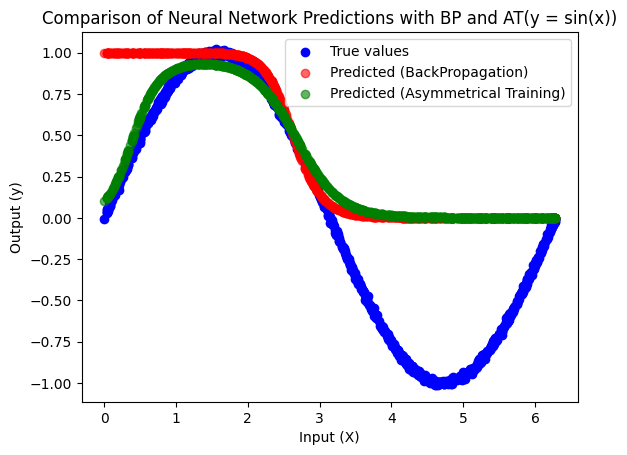

In [47]:

# AT algorithm exceution
if __name__ == '__main__':
    import matplotlib.pyplot as plt
    import numpy as np

    # Initialize the neural network with the given structure and activation functions
    nn1 = NeuralNetwork([1, 100, 1], activations=['sigmoid', 'sigmoid'])
    nn2 = NeuralNetwork([1, 100, 1], activations=['sigmoid', 'sigmoid'])

    # Generate the input data X and the corresponding output data y
    X = 2 * np.pi * np.random.rand(1000).reshape(1, -1)
    y_digital = np.sin(X)

    # generate the inaccurate physical data by adding some noise to the digital data
    noise = np.random.normal(0, 0.01, y.shape)  # Mean = 0, standard deviation = 0.01
    y = y_digital + noise

    # Train the neural network using the standard BackPropagation method
    nn1.train(X, y, epochs=10000, batch_size=64, lr=0.1)
    # Perform a feedforward pass to get the final output    
    _, a_so = nn1.feedforward_parallel(X)
    
    # Train the neural network using the Asymmetrical Training method
    nn2.ATtrain(X, y, y_digital, epochs=10000, batch_size=64, lr=0.1, Mw1=0.5, Mw2=0.5)

    # Perform a feedforward pass to get the final output
    _, a_s = nn2.feedforward_parallel(X)

    # Plot the original data and the neural network's predictions for both methods on the same graph
    plt.scatter(X.flatten(), y.flatten(), label='True values', color='blue')
    plt.scatter(X.flatten(), a_so[-1].flatten(), label='Predicted (BackPropagation)', color='red', alpha=0.6)
    plt.scatter(X.flatten(), a_s[-1].flatten(), label='Predicted (Asymmetrical Training)', color='green', alpha=0.6)

    # Add title and labels
    plt.title('Comparison of Neural Network Predictions with BP and AT(y = sin(x))')
    plt.xlabel('Input (X)')
    plt.ylabel('Output (y)')

    # Add legend and show the plot
    plt.legend()
    plt.show()
